# Train and evaluate stationary, linear envrionments

>  tests different bandit agents against stationary linear environments

By the end of this notebook, you will have logged training params and metrics to Vertex Experiments, creating a dashboard like this:

<img src="imgs/vertex_experiments_linear_bandits.png" 
     align="center" 
     width="850"
     height="850"/>

### Load env config

* use the prefix from `00-env-setup`

In [2]:
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [3]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"
VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NAME      = "training_dataset"

REPOSITORY               = "rl-movielens-rec-bandits-v2"

DOCKERNAM

### imports

In [4]:
import functools

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# logging
import logging
logging.disable(logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf
from tf_agents.bandits.agents import exp3_mixture_agent
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.bandits.agents import neural_boltzmann_agent
from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.environments import stationary_stochastic_py_environment as sspe
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.environments import tf_py_environment
from tf_agents.environments import wrappers
from tf_agents.networks import q_network
from tf_agents.policies import utils as policy_utilities

# google cloud
from google.cloud import aiplatform, storage

# GPU
from numba import cuda 
import gc

import sys
sys.path.append("..")

from src.utils import policy_util

### Set GPU (local) device

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

In [9]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

### Set dimensions

In [10]:
# normalize_reward_fns - Whether to normalize the reward functions so that rewards are close to being in [0, 1].
NORMALIZE_REWARD_FN = False # True | False

# num_disabled_actions - If non-zero, there will be extra actions that are always disabled
NUM_DISABLED_ACTIONS = 0 

In [11]:
BATCH_SIZE = 8
CONTEXT_DIM = 15
NUM_ACTIONS = 5
REWARD_NOISE_VARIANCE = 0.01
# AGENT_ALPHA = 0.1
# TEMPERATURE = 0.1

# EPSILON = 0.05
# LAYERS = [50, 50, 50]
# LR = 0.001

## [1] Define simulation environment

In [12]:
if NORMALIZE_REWARD_FN:
    action_reward_fns = (
        environment_utilities.normalized_sliding_linear_reward_fn_generator(
            CONTEXT_DIM, 
            NUM_ACTIONS, 
            REWARD_NOISE_VARIANCE
        )
    )
else:
    action_reward_fns = (
        environment_utilities.sliding_linear_reward_fn_generator(
            CONTEXT_DIM, 
            NUM_ACTIONS, 
            REWARD_NOISE_VARIANCE
        )
    )
    
action_reward_fns

In [13]:
env = sspe.StationaryStochasticPyEnvironment(
    functools.partial(
        environment_utilities.context_sampling_fn,
        batch_size=BATCH_SIZE,
        context_dim=CONTEXT_DIM,
    ),
    action_reward_fns,
    batch_size=BATCH_SIZE,
)

mask_split_fn = None

if NUM_DISABLED_ACTIONS > 0:
    mask_split_fn = lambda x: (x[0], x[1])
    env = wrappers.ExtraDisabledActionsWrapper(
        env, 
        NUM_DISABLED_ACTIONS
    )
    
environment = tf_py_environment.TFPyEnvironment(env)
environment

### Optimal rewards and actions

In [14]:
optimal_reward_fn = functools.partial(
    environment_utilities.tf_compute_optimal_reward,
    per_action_reward_fns=action_reward_fns,
)

optimal_action_fn = functools.partial(
    environment_utilities.tf_compute_optimal_action,
    per_action_reward_fns=action_reward_fns,
)

## [2] Train Bandit policy

### Network

> use a network to define the model that is trained by an agent

`QNetwork`: 
* Used in Qlearning for environments with discrete actions, this network maps an observation to value estimates for each possible action.

In [15]:
LAYERS = [32,16,8]

network_input_spec = environment.time_step_spec().observation
network_input_spec

TensorSpec(shape=(15,), dtype=tf.float32, name=None)

In [16]:
if NUM_DISABLED_ACTIONS > 0:
    def _apply_only_to_observation(fn):
        def result_fn(obs):
            return fn(obs[0])

        return result_fn

    optimal_action_fn = _apply_only_to_observation(optimal_action_fn)
    optimal_reward_fn = _apply_only_to_observation(optimal_reward_fn)
    network_input_spec = network_input_spec[0]
    
network = q_network.QNetwork(
        input_tensor_spec=network_input_spec,
        action_spec=environment.action_spec(),
        fc_layer_params=LAYERS,
    )

### Defining the Agent

*Documentation references:*
* [LinearUCBAgent](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/lin_ucb_agent/LinearUCBAgent)
* [LinearThompsonSamplingAgent](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/linear_thompson_sampling_agent/LinearThompsonSamplingAgent)
* [NeuralBoltzmannAgent](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/neural_boltzmann_agent/NeuralBoltzmannAgent)
* [Exp3MixtureAgent](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/exp3_mixture_agent/Exp3MixtureAgent)

*helper function...*

In [17]:
def _get_bandit_agent(
    AGENT_TYPE, 
    environment, 
    AGENT_ALPHA, 
    TEMPERATURE, 
    LR, 
    NUM_DISABLED_ACTIONS, 
    EPSILON,
    FORGETTING_FACTOR,
    DEBUG_BOOL = True,
    SUMMARIZE_GRADS_AND_VARS = True,
    ENABLE_SUMMARIES = True,
):
                      
    if AGENT_TYPE == 'LinUCB':
        agent = lin_ucb_agent.LinearUCBAgent(
            time_step_spec=environment.time_step_spec(),
            action_spec=environment.action_spec(),
            alpha=AGENT_ALPHA,
            dtype=tf.float32,
            observation_and_action_constraint_splitter=mask_split_fn,
            debug_summaries=DEBUG_BOOL,
            summarize_grads_and_vars=SUMMARIZE_GRADS_AND_VARS,
            enable_summaries=ENABLE_SUMMARIES,
            gamma = FORGETTING_FACTOR,
        )
        EPSILON = "N/A"
        NETWORK_TYPE = "N/A"
    elif AGENT_TYPE == 'LinTS':
        agent = lin_ts_agent.LinearThompsonSamplingAgent(
            time_step_spec=environment.time_step_spec(),
            action_spec=environment.action_spec(),
            alpha=AGENT_ALPHA,
            dtype=tf.float32,
            observation_and_action_constraint_splitter=mask_split_fn,
            debug_summaries=DEBUG_BOOL,
            summarize_grads_and_vars=SUMMARIZE_GRADS_AND_VARS,
            enable_summaries=ENABLE_SUMMARIES,
            gamma = FORGETTING_FACTOR,
        )
        EPSILON = "N/A"
        NETWORK_TYPE = "N/A"
    elif AGENT_TYPE == 'epsGreedy':
        agent = neural_epsilon_greedy_agent.NeuralEpsilonGreedyAgent(
            time_step_spec=environment.time_step_spec(),
            action_spec=environment.action_spec(),
            reward_network=network,
            optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
            epsilon=EPSILON,
            observation_and_action_constraint_splitter=mask_split_fn,
            debug_summaries=DEBUG_BOOL,
            summarize_grads_and_vars=SUMMARIZE_GRADS_AND_VARS,
            enable_summaries=ENABLE_SUMMARIES,
        )
        FORGETTING_FACTOR = "N/A"
        AGENT_ALPHA = "N/A"
        NETWORK_TYPE = network.name
    elif AGENT_TYPE == 'Boltzmann':
        '''
        agent receives a neural network that it trains to predict rewards. 
        The action is chosen by a stochastic policy that uses Boltzmann exploration
        '''
        train_step_counter = tf.compat.v1.train.get_or_create_global_step()
        boundaries = [500]
        temp_values = [1000.0, TEMPERATURE]
        temp_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries, 
            temp_values
        )

        def _temperature_fn():
            # Any variable used in the function needs to be saved in the policy.
            # This is true by default for the `train_step_counter`.
            return temp_schedule(train_step_counter)

        agent = neural_boltzmann_agent.NeuralBoltzmannAgent(
            time_step_spec=environment.time_step_spec(),
            action_spec=environment.action_spec(),
            reward_network=network,
            temperature=_temperature_fn,
            optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
            observation_and_action_constraint_splitter=mask_split_fn,
            train_step_counter=train_step_counter,
        )
        # This is needed, otherwise the PolicySaver complains.
        agent.policy.step = train_step_counter
        FORGETTING_FACTOR = "N/A"
        EPSILON = "N/A"
        NETWORK_TYPE = network.name
    elif AGENT_TYPE == 'BoltzmannGumbel':
        '''
        agent implements Neural Bandit with Boltzmann-Gumbel exploration from the paper: 
            N. Cesa-Bianchi et al., "Boltzmann Exploration Done Right", NIPS 2017
            
        TODO:
            (1) Can we log exploration factor so it's consistent with "epsilon"?
        '''
        
        num_samples_list = [
            tf.compat.v2.Variable(
                0, 
                dtype=tf.int64, 
                name='num_samples_{}'.format(k)
            ) for k in range(NUM_ACTIONS)
        ]
        agent = neural_boltzmann_agent.NeuralBoltzmannAgent(
            time_step_spec=environment.time_step_spec(),
            action_spec=environment.action_spec(),
            reward_network=network,
            boltzmann_gumbel_exploration_constant=250.0,
            optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
            observation_and_action_constraint_splitter=mask_split_fn,
            num_samples_list=num_samples_list,
        )
        AGENT_ALPHA = "N/A"
        FORGETTING_FACTOR = "N/A"
        EPSILON = "N/A"
        NETWORK_TYPE = network.name
    elif AGENT_TYPE == 'Mix':
        '''
        Creates an agent that mixes a set of agents and updates the weights with Exp3
            The update uses a modified version of EXP3 to better distribute weights to all agents
            
        To smooth the weights, two extra measures are taken:
            (1) forgetting factor: ensures the aggregated reward estimates do not grow indefinitely
            (2) inverse temperature: has a maximum parameter that prevents it from growing indefinitely 
        For both smoothing factors to work nicely, recommended to set:
            forgetting_factor = 1 - (1 / max_inverse_temperature)
            
        For every data sample, the agent updates the sub-agent that was used to make 
            the action choice in that sample. For this update to happen, the mixture agent 
            needs to have the information on which sub-agent is "responsible" for the action. 
            This information is in a policy info field `mixture_choice_info`
        '''
        assert (NUM_DISABLED_ACTIONS == 0), 'Extra actions with mixture agent not supported.'

        emit_policy_info = policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN

        agent_linucb = lin_ucb_agent.LinearUCBAgent(
            time_step_spec=environment.time_step_spec(),
            action_spec=environment.action_spec(),
            emit_policy_info=emit_policy_info,
            alpha=AGENT_ALPHA,
            dtype=tf.float32,
            debug_summaries=DEBUG_BOOL,
            summarize_grads_and_vars=SUMMARIZE_GRADS_AND_VARS,
            enable_summaries=ENABLE_SUMMARIES,
            # gamma = FORGETTING_FACTOR,
        )
        agent_lints = lin_ts_agent.LinearThompsonSamplingAgent(
            time_step_spec=environment.time_step_spec(),
            action_spec=environment.action_spec(),
            emit_policy_info=emit_policy_info,
            alpha=AGENT_ALPHA,
            dtype=tf.float32,
            debug_summaries=DEBUG_BOOL,
            summarize_grads_and_vars=SUMMARIZE_GRADS_AND_VARS,
            enable_summaries=ENABLE_SUMMARIES,
            # gamma = FORGETTING_FACTOR,
        )
        agent_epsgreedy = neural_epsilon_greedy_agent.NeuralEpsilonGreedyAgent(
            time_step_spec=environment.time_step_spec(),
            action_spec=environment.action_spec(),
            reward_network=network,
            optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
            emit_policy_info=emit_policy_info,
            epsilon=EPSILON,
            debug_summaries=DEBUG_BOOL,
            summarize_grads_and_vars=SUMMARIZE_GRADS_AND_VARS,
            enable_summaries=ENABLE_SUMMARIES,
        )
        agent = exp3_mixture_agent.Exp3MixtureAgent(
            agents = (
                agent_linucb, 
                agent_lints, 
                agent_epsgreedy
            ),
            forgetting = FORGETTING_FACTOR,
            # max_inverse_temperature = MAX_INVERSE_TEMP
        )
        NETWORK_TYPE = network.name
        agent.initialize()
    
    AGENT_CONFIG = {
        "network": NETWORK_TYPE,
        "agent" : agent,
        "agent_type": agent.name,
        "alpha" : AGENT_ALPHA,
        "temp": TEMPERATURE,
        "lr": LR,
        "disabled_actions": NUM_DISABLED_ACTIONS,
        "epsilon": EPSILON,
        "forget": FORGETTING_FACTOR,
        "summaries": str(ENABLE_SUMMARIES),
    }
    
    pprint(AGENT_CONFIG)
    
    return AGENT_CONFIG

*Agent config*

**Temperature**
* Temperature is a parameter that is used in the Boltzmann exploration algorithm. It controls the amount of exploration that the agent does. 
  * High == the agent is more likely to explore new actions
  * Low == the agent is more likely to exploit the actions that it has already learned.
  
**Forgetting Factor / Gamma**
* a float forgetting factor in [0.0, 1.0]. When set to 1.0, the algorithm does not forget

In [18]:
# agent - Which agent to use
AGENT_TYPE = 'epsGreedy' # 'LinUCB', 'LinTS', 'epsGreedy', 'Mix', 'Boltzmann', 'BoltzmannGumbel'

AGENT_ALPHA = 0.1

# explore vs exploit
EPSILON = 0.05
TEMPERATURE = 0.05

LR = 0.001

FORGETTING_FACTOR = 0.98 # 0.99 | 0.98 | 0.9 

In [19]:
agent_config = _get_bandit_agent(
    AGENT_TYPE = AGENT_TYPE, 
    environment = environment, 
    AGENT_ALPHA = AGENT_ALPHA, 
    TEMPERATURE = TEMPERATURE, 
    LR = LR, 
    NUM_DISABLED_ACTIONS = NUM_DISABLED_ACTIONS,
    FORGETTING_FACTOR = FORGETTING_FACTOR,
    EPSILON = EPSILON,
    DEBUG_BOOL = True,
    SUMMARIZE_GRADS_AND_VARS = True,
    ENABLE_SUMMARIES = True,
)

{'agent': <tf_agents.bandits.agents.neural_epsilon_greedy_agent.NeuralEpsilonGreedyAgent object at 0x7f8c425f0340>,
 'agent_type': 'neural_epsilon_greedy_agent',
 'alpha': 'N/A',
 'disabled_actions': 0,
 'epsilon': 0.05,
 'forget': 'N/A',
 'lr': 0.001,
 'network': 'QNetwork',
 'summaries': 'True',
 'temp': 0.05}


In [20]:
global_step = tf.compat.v1.train.get_or_create_global_step()
global_step

<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=0>

### Regret and SubOptimal Arm metrics

In [21]:
regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)

suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
    optimal_action_fn
)

metrics = [regret_metric, suboptimal_arms_metric]

## [3] Vertex AI Experiments

In [22]:
LOCAL_VERSION = "v3"

In [23]:
EXPERIMENT_NAME   = f'01-linear-bandits-{LOCAL_VERSION}'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'{AGENT_TYPE}-{invoke_time}'.lower()

BASE_OUTPUT_DIR   = f'{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}'
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : 01-linear-bandits-v3
RUN_NAME          : epsgreedy-20240313-181820

BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/01-linear-bandits-v3/epsgreedy-20240313-181820
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/01-linear-bandits-v3/epsgreedy-20240313-181820/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/01-linear-bandits-v3/epsgreedy-20240313-181820/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/01-linear-bandits-v3/epsgreedy-20240313-181820/artifacts


### TensorBoard

In [24]:
# NEW_TENSORBOARD = False

In [25]:
# if NEW_TENSORBOARD:
#     # # create new TB instance
#     TENSORBOARD_DISPLAY_NAME=f"{EXPERIMENT_NAME}"

#     tensorboard = aiplatform.Tensorboard.create(
#         display_name=TENSORBOARD_DISPLAY_NAME
#         , project=PROJECT_ID
#         , location=REGION
#     )

#     TB_RESOURCE_NAME = tensorboard.resource_name
# else:
#     # use existing TB instance
#     TB_RESOURCE_NAME = 'projects/934903580331/locations/us-central1/tensorboards/8118622335684050944' # TODO
#     tensorboard = aiplatform.Tensorboard(
#         tensorboard_name=TB_RESOURCE_NAME
#     )

# TB_ID = TB_RESOURCE_NAME.split('/')[-1]

# print(f"TB_RESOURCE_NAME : {TB_RESOURCE_NAME}")
# print(f"TB display name  : {tensorboard.display_name}")
# print(f"TB_ID            : {TB_ID}")

In [26]:
# # Delete Tensorboard
# vertex_ai_tb.delete()

### Initialize Vertex Experiment autologging

A default TensorBoard instance is automatically created when initializing a Vertex AI experiment. This backing TensorBoard is associated with the Vertex AI experiment and is used with all subsequent Vertex AI Experiments runs. This is the easiest way to get started with Vertex AI TensorBoard and should meet most users needs - [src](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-setup#use_default_instance)

* If `experiment_tensorboard` is provided and `experiment` is not, the provided `experiment_tensorboard` will be set as the global Tensorboard
* Any subsequent calls to aiplatform.init() with `experiment` and without `experiment_tensorboard` will automatically assign the global Tensorboard to the `experiment`

If `experiment_tensorboard` is ommitted or set to `True` or `None` the global Tensorboard will be assigned to the `experiment`
* If a global Tensorboard is not set, the default Tensorboard instance will be used, and created if it deos not exist.
* To disable creating and using Tensorboard with `experiment`, set `experiment_tensorboard` to False.
* Any subsequent calls to aiplatform.init() should include this setting as well.

**references**
* `aiplatform.init()` [src](https://github.com/googleapis/python-aiplatform/blob/main/google/cloud/aiplatform/initializer.py#L125)

In [27]:
aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME,
    # experiment_tensorboard=TB_ID # TB_ID
)

## [4] Bandit Training

### train config

In [29]:
TEST_HPT_FLAG  = False # True | False

_ARTIFACTS_DIR = ARTIFACTS_DIR if not TEST_HPT_FLAG else None
_ROOT_DIR      = ROOT_DIR if not TEST_HPT_FLAG else None

print(f"TEST_HPT_FLAG  : {TEST_HPT_FLAG}")
print(f"_ARTIFACTS_DIR : {_ARTIFACTS_DIR}")
print(f"_ROOT_DIR      : {_ROOT_DIR}")

TRAINING_LOOPS = 50
STEPS_PER_LOOP = 1
LOG_INTERVAL = TRAINING_LOOPS // 10

print(f"TRAINING_LOOPS : {TRAINING_LOOPS}")
print(f"STEPS_PER_LOOP : {STEPS_PER_LOOP}")
print(f'LOG_INTERVAL   : {LOG_INTERVAL}')

summary_writer = tf.summary.create_file_writer(LOG_DIR)
summary_writer.set_as_default()

TEST_HPT_FLAG  : False
_ARTIFACTS_DIR : gs://rec-bandits-v2-hybrid-vertex-bucket/01-linear-bandits-v3/epsgreedy-20240313-181820/artifacts
_ROOT_DIR      : gs://rec-bandits-v2-hybrid-vertex-bucket/01-linear-bandits-v3/epsgreedy-20240313-181820/root
TRAINING_LOOPS : 50
STEPS_PER_LOOP : 1
LOG_INTERVAL   : 5


Start experiment run...

### Train loop

In [30]:
#start the timer and training
start_time = time.time()

metric_results = policy_util.train(
    agent=agent_config['agent'],
    environment=environment,
    log_dir=LOG_DIR,
    # model_dir = BASE_OUTPUT_DIR,
    chkpt_dir = f"{BASE_OUTPUT_DIR}/chkpts",
    training_loops=TRAINING_LOOPS,
    steps_per_loop=STEPS_PER_LOOP,
    additional_metrics=metrics,
    # save_policy=True,
    artifacts_dir=_ARTIFACTS_DIR,
    root_dir=_ROOT_DIR,
    run_hyperparameter_tuning=TEST_HPT_FLAG,
    profiler = False,
    train_summary_writer = summary_writer,
    chkpt_interval = 10,
    global_step = global_step
)

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"train runtime_mins: {runtime_mins}")

step = 0: train loss = 106353.5390625
step = 10: train loss = 97752.3828125
step = 20: train loss = 61646.22265625
step = 30: train loss = 57903.44140625
step = 40: train loss = 30463.337890625
runtime_mins: 3
saved policy checkpoint to: gs://rec-bandits-v2-hybrid-vertex-bucket/01-linear-bandits-v3/epsgreedy-20240313-181820/chkpts
train runtime_mins: 3


In [31]:
# aiplatform.end_run()
# vertex_ai.autolog(disable=True)

pprint(metric_results.keys())

dict_keys(['NumberOfEpisodes', 'EnvironmentSteps', 'AverageEpisodeLengthMetric', 'RegretMetric', 'SuboptimalArmsMetric', 'AverageReturnMetric'])


### plot bandit metrics

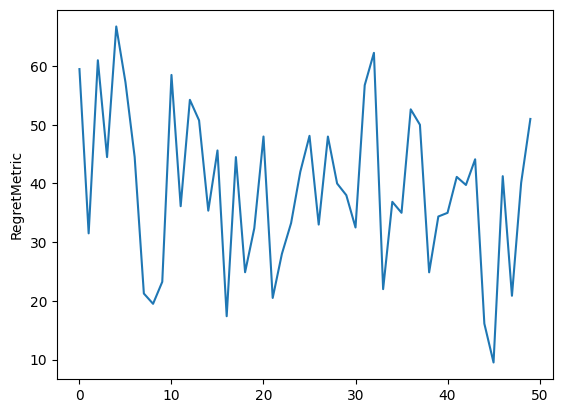

In [32]:
plt.plot(metric_results['RegretMetric'])
plt.ylabel('RegretMetric')
plt.show()

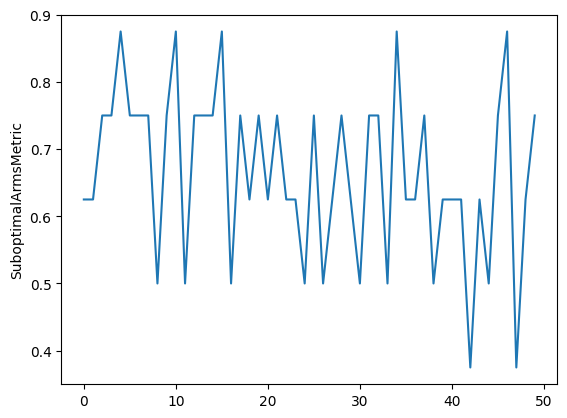

In [33]:
plt.plot(metric_results['SuboptimalArmsMetric'])
plt.ylabel('SuboptimalArmsMetric')
plt.show()

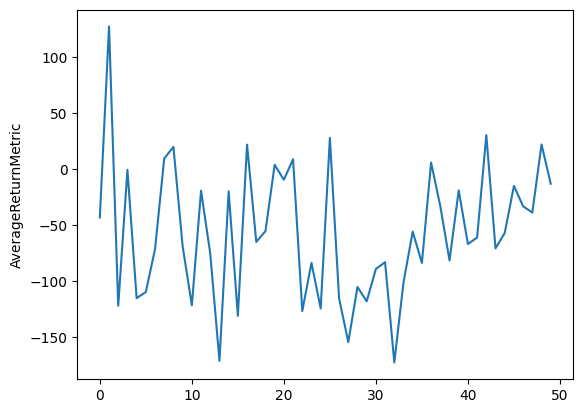

In [34]:
plt.plot(metric_results['AverageReturnMetric'])
plt.ylabel('AverageReturnMetric')
plt.show()

## [5] View policy gradients and network variables with TensorBoard

In [35]:
# %load_ext tensorboard
# %reload_ext tensorboard

In [36]:
# %tensorboard --logdir=$LOG_DIR 

## [6] Log bandit metrics and params to Vertex Experiments

In [37]:
# gather the param values
exp_params = {
    "agent": agent_config['agent_type']
    , "network": agent_config['network']
    , "layers": str(LAYERS)
    , "batch_size": BATCH_SIZE
    , "training_loops": TRAINING_LOOPS
    # , "steps_per_loop": STEPS_PER_LOOP
    # , "lr": LR
    , "context_dim": CONTEXT_DIM
    , "num_actions": NUM_ACTIONS
    , "epsilon": agent_config['epsilon']
    , "forget" : agent_config['forget']
    , "temp" : agent_config['temp']
    , "agent_alpha": agent_config['alpha']
    , "runtime": runtime_mins
    , "per_arm": "False"
}

pprint(exp_params)

{'agent': 'neural_epsilon_greedy_agent',
 'agent_alpha': 'N/A',
 'batch_size': 8,
 'context_dim': 15,
 'epsilon': 0.05,
 'forget': 'N/A',
 'layers': '[32, 16, 8]',
 'network': 'QNetwork',
 'num_actions': 5,
 'per_arm': 'False',
 'runtime': 3,
 'temp': 0.05,
 'training_loops': 50}


In [38]:
# log results to Vertex Experiment

# gather the metrics for the last epoch to be saved in metrics
exp_metrics = {
    # "AvgReturn" : round(float(metric_results["AverageReturnMetric"][-1]),2)
    "FinalRegret" : round(float(metric_results["RegretMetric"][-1]),2)
    # , "SuboptimalArms" : round(float(metric_results["SuboptimalArmsMetric"][-1]),2)
}

pprint(exp_metrics)

{'FinalRegret': 51.0}


In [39]:
aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME,
    # experiment_tensorboard=TB_ID
)

with aiplatform.start_run(
    f'{RUN_NAME}',
) as my_run:

    logging.info(f"logging metrics...")

    my_run.log_params(exp_params)
    my_run.log_metrics(exp_metrics)
    print(f"logging time-series metrics...")
    for i in range(0, len(metric_results["RegretMetric"])):
        aiplatform.log_time_series_metrics({'RegretMetric': metric_results["RegretMetric"][i]}, step=i)
        aiplatform.log_time_series_metrics({'AverageReturnMetric': metric_results["AverageReturnMetric"][i]}, step=i)
        aiplatform.log_time_series_metrics({'SuboptimalArmsMetric': metric_results["SuboptimalArmsMetric"][i]}, step=i)

    aiplatform.end_run()

logging time-series metrics...


## [7] Running an experiment 

> see [docs](https://cloud.google.com/vertex-ai/docs/experiments/create-manage-exp-run#create-and-start-run) for more on Vertex Ai Experiments

In [45]:
LOCAL_EXP_VERSION = "v1"
EXPERIMENT_NAME = f"01d-linear-reward-bandits-{LOCAL_EXP_VERSION}"

#### helper function

In [46]:
from tf_agents.environments import TFEnvironment

def run_bandit_experiment(
    experiment_name: str,
    experiment_run: str,
    agent_type: str,
    agent_alpha: float,
    epsilon: float,
    temperature: float,
    learning_rate: float,
    forgetting_factor: float,
    env: TFEnvironment,
    training_loops: int,
    base_output_dir: str,
    log_dir: str,
    root_dir: str,
    artifacts_dir: str,
    test_hpt_flag: bool = False,
):
    
    summary_writer = tf.summary.create_file_writer(LOG_DIR)
    summary_writer.set_as_default()

    _ARTIFACTS_DIR = artifacts_dir if not test_hpt_flag else None
    _ROOT_DIR      = root_dir if not test_hpt_flag else None
    
    _agent_config = _get_bandit_agent(
        AGENT_TYPE = agent_type, 
        environment = env, 
        AGENT_ALPHA = agent_alpha, 
        TEMPERATURE = temperature, 
        LR = learning_rate, 
        NUM_DISABLED_ACTIONS = NUM_DISABLED_ACTIONS,
        FORGETTING_FACTOR = forgetting_factor,
        EPSILON = epsilon,
        DEBUG_BOOL = True,
        SUMMARIZE_GRADS_AND_VARS = True,
        ENABLE_SUMMARIES = True,
    )

    global_step = tf.compat.v1.train.get_or_create_global_step()
    
    #start the timer and training
    start_time = time.time()
    metric_results = policy_util.train(
        agent= _agent_config['agent'],
        environment=env,
        log_dir=LOG_DIR,
        # model_dir = base_output_dir,
        chkpt_dir = f"{base_output_dir}/chkpts",
        training_loops=training_loops,
        steps_per_loop=1,
        additional_metrics=metrics,
        # save_policy=True,
        artifacts_dir=_ARTIFACTS_DIR,
        root_dir=_ROOT_DIR,
        run_hyperparameter_tuning=test_hpt_flag,
        profiler = False,
        train_summary_writer = summary_writer,
        chkpt_interval = 10,
        global_step = global_step
    )
    runtime_mins = int((time.time() - start_time) / 60)
    print(f"train runtime_mins: {runtime_mins}")

    # log Vertex Experiments
    exp_params = {
        "agent": _agent_config['agent_type']
        , "network": _agent_config['network']
        , "layers": str(LAYERS)
        , "batch_size": BATCH_SIZE
        , "training_loops": training_loops
        # , "steps_per_loop": STEPS_PER_LOOP
        # , "lr": LR
        , "context_dim": CONTEXT_DIM
        , "num_actions": NUM_ACTIONS
        , "epsilon": _agent_config['epsilon']
        , "forget" : _agent_config['forget']
        , "temp" : _agent_config['temp']
        , "agent_alpha": _agent_config['alpha']
        , "runtime": runtime_mins
        , "per_arm": "False"
    }

    # gather the metrics for the last epoch to be saved in metrics
    exp_metrics = {
        # "AvgReturn" : round(float(metric_results["AverageReturnMetric"][-1]),2)
        "FinalRegret" : round(float(metric_results["RegretMetric"][-1]),2)
        # , "SuboptimalArms" : round(float(metric_results["SuboptimalArmsMetric"][-1]),2)
    }
    
    with aiplatform.start_run(
        f'{experiment_run}',
    ) as my_run:

        logging.info(f"logging metrics...")

        my_run.log_params(exp_params)
        my_run.log_metrics(exp_metrics)
        print(f"logging time-series metrics...")
        for i in range(0, len(metric_results["RegretMetric"])):
            aiplatform.log_time_series_metrics({'RegretMetric': metric_results["RegretMetric"][i]}, step=i)
            aiplatform.log_time_series_metrics({'AverageReturnMetric': metric_results["AverageReturnMetric"][i]}, step=i)
            aiplatform.log_time_series_metrics({'SuboptimalArmsMetric': metric_results["SuboptimalArmsMetric"][i]}, step=i)

        aiplatform.end_run()
        
    print(f"Finished logging {experiment_run} metrics to Vertex AI\n")
        
    return metric_results

### set experiment config

In [48]:
# aiplatform.init(
#     project=PROJECT_ID,
#     location=REGION,
#     experiment=EXPERIMENT_NAME,
# )

In [49]:
# agent - Which agent to use
AGENT_TYPE    = 'epsGreedy' # 'LinUCB', 'LinTS', 'epsGreedy', 'Mix', 'Boltzmann', 'BoltzmannGumbel'
AGENT_ALPHA   = 0.1

# explore vs exploit
EPSILON       = 0.05
TEMPERATURE   = 0.05
LR            = 0.001
FORGET_FACTOR = 0.98 # 0.99 | 0.98 | 0.9 

# train job
TRAINING_LOOPS=50
STEPS_PER_LOOP=1

# config dicts
exp_configs = []
# exp_vars = [0.05,0.10,0.15]
exp_vars = ['LinUCB', 'LinTS', 'epsGreedy']

for VAR in exp_vars:
    
    config = {
        "agent_type": VAR, # vars are agent types in this example
        "experiment_name": EXPERIMENT_NAME,
        "experiment_run_tag": VAR,
        "agent_alpha": AGENT_ALPHA,
        "epsilon": EPSILON,
        "temperature": TEMPERATURE,
        "learning_rate": LR,
        "forgetting_factor": FORGET_FACTOR,
        "training_loops": TRAINING_LOOPS,
        "environment": environment,
    }
    exp_configs.append(config)
    
print(f"len(configs): {len(exp_configs)}")

exp_configs

len(configs): 3


[{'agent_type': 'LinUCB',
  'experiment_name': '01d-linear-reward-bandits-v1',
  'experiment_run_tag': 'LinUCB',
  'agent_alpha': 0.1,
  'epsilon': 0.05,
  'temperature': 0.05,
  'learning_rate': 0.001,
  'forgetting_factor': 0.98,
  'training_loops': 50,
  'environment': <tf_agents.environments.tf_py_environment.TFPyEnvironment at 0x7f8cfe6a4310>},
 {'agent_type': 'LinTS',
  'experiment_name': '01d-linear-reward-bandits-v1',
  'experiment_run_tag': 'LinTS',
  'agent_alpha': 0.1,
  'epsilon': 0.05,
  'temperature': 0.05,
  'learning_rate': 0.001,
  'forgetting_factor': 0.98,
  'training_loops': 50,
  'environment': <tf_agents.environments.tf_py_environment.TFPyEnvironment at 0x7f8cfe6a4310>},
 {'agent_type': 'epsGreedy',
  'experiment_name': '01d-linear-reward-bandits-v1',
  'experiment_run_tag': 'epsGreedy',
  'agent_alpha': 0.1,
  'epsilon': 0.05,
  'temperature': 0.05,
  'learning_rate': 0.001,
  'forgetting_factor': 0.98,
  'training_loops': 50,
  'environment': <tf_agents.environm

### run experiment

In [50]:
all_metrics = {}

for config in exp_configs:
    print("Beginning new run...")
    
    invoke_time = time.strftime("%Y%m%d-%H%M%S")
    RUN_NAME    = f"{config['experiment_run_tag']}-{invoke_time}".lower()
    print(f"Experiment name: {config['experiment_name']}")
    print(f"Experiment run : {RUN_NAME}\n")
    
    BASE_OUTPUT_DIR   = f'{BUCKET_URI}/{config["experiment_name"]}/{RUN_NAME}'
    LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
    ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"
    ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"
    
    run_metrics = run_bandit_experiment(
        experiment_name = config['experiment_name'],
        experiment_run = RUN_NAME,
        agent_type = config['agent_type'],
        agent_alpha = config['agent_alpha'],
        epsilon = config['epsilon'],
        temperature = config['temperature'],
        learning_rate = config['learning_rate'],
        forgetting_factor = config['forgetting_factor'],
        env = config['environment'],
        training_loops = config["training_loops"],
        test_hpt_flag=False,
        base_output_dir=BASE_OUTPUT_DIR,
        log_dir = LOG_DIR,
        root_dir = ROOT_DIR,
        artifacts_dir = ARTIFACTS_DIR,
    )
    
    all_metrics[f"{config['experiment_run_tag']}"] = {
        "run_name": RUN_NAME,
        "log_dir" : LOG_DIR,
        "metrics": run_metrics
    }

Beginning new run...
Experiment name: 01d-linear-reward-bandits-v1
Experiment run : linucb-20240313-183942

{'agent': <tf_agents.bandits.agents.lin_ucb_agent.LinearUCBAgent object at 0x7f8cfe6a4b20>,
 'agent_type': 'linear_ucb_agent',
 'alpha': 0.1,
 'disabled_actions': 0,
 'epsilon': 'N/A',
 'forget': 0.98,
 'lr': 0.001,
 'network': 'N/A',
 'summaries': 'True',
 'temp': 0.05}
step = 0: train loss = 34837.46875
step = 10: train loss = 3640.1787109375
step = 20: train loss = 0.6676999926567078
step = 30: train loss = 0.05460000038146973
step = 40: train loss = 0.00419999985024333
runtime_mins: 3
saved policy checkpoint to: gs://rec-bandits-v2-hybrid-vertex-bucket/01d-linear-reward-bandits-v1/linucb-20240313-183942/chkpts
train runtime_mins: 3
logging time-series metrics...
Finished logging linucb-20240313-183942 metrics to Vertex AI

Beginning new run...
Experiment name: 01d-linear-reward-bandits-v1
Experiment run : lints-20240313-184305

{'agent': <tf_agents.bandits.agents.linear_thomp

In [ ]:
# all_metrics['LinUCB']['run_name']
# all_metrics['LinUCB']['log_dir']
# all_metrics['LinUCB']['metrics']['RegretMetric']
# all_metrics['LinUCB']['metrics']['AverageReturnMetric']
# all_metrics['LinUCB']['metrics']['SuboptimalArmsMetric']

In [51]:
all_regrets = {}
all_avg_returns = {}
all_suboptimals = {}
all_tags = []
all_run_names = []

for x in exp_configs:
    
    tag = x['experiment_run_tag']
    all_tags.append(tag)
    all_run_names.append(all_metrics[tag]['run_name'])
    
    all_regrets[tag] = all_metrics[tag]['metrics']['RegretMetric']
    all_avg_returns[tag] = all_metrics[tag]['metrics']['AverageReturnMetric']
    all_suboptimals[tag] = all_metrics[tag]['metrics']['SuboptimalArmsMetric']
    
regret_df = pd.DataFrame(all_regrets)
avg_return_df = pd.DataFrame(all_avg_returns)
suboptimal_df = pd.DataFrame(all_suboptimals)

In [52]:
all_tags

['LinUCB', 'LinTS', 'epsGreedy']

#### plot metrics

In [53]:
# import seaborn as sns
FONT_SIZE = 10
FIG_SIZE = (10,4)
# plt.style.use('fivethirtyeight')
plt.style.use('default') 

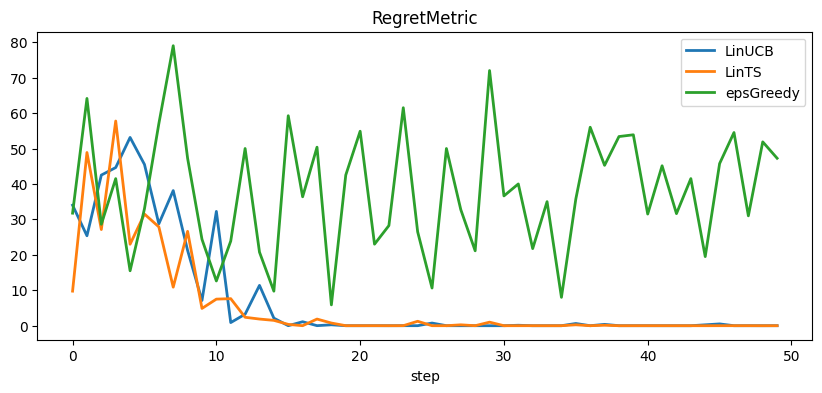

In [54]:
ax = regret_df.plot(linewidth=2, fontsize=FONT_SIZE, figsize=FIG_SIZE);

# Additional customizations
ax.set_title("RegretMetric")
ax.set_xlabel('step');
ax.legend(fontsize=FONT_SIZE);

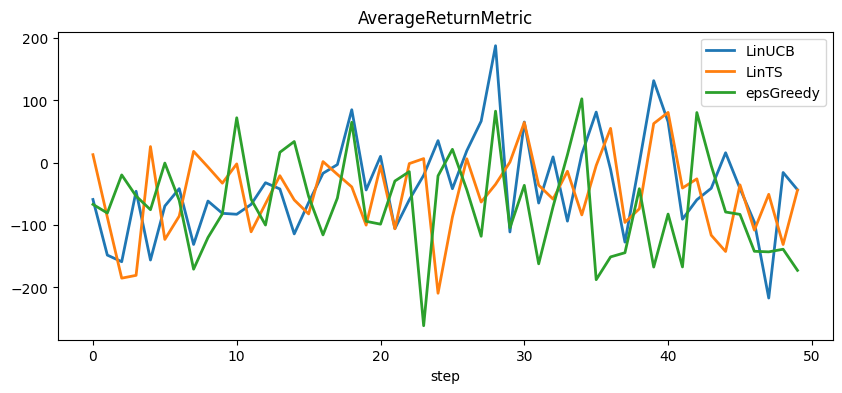

In [55]:
ax = avg_return_df.plot(linewidth=2, fontsize=FONT_SIZE, figsize=FIG_SIZE);

# Additional customizations
ax.set_title("AverageReturnMetric")
ax.set_xlabel('step');
ax.legend(fontsize=FONT_SIZE);

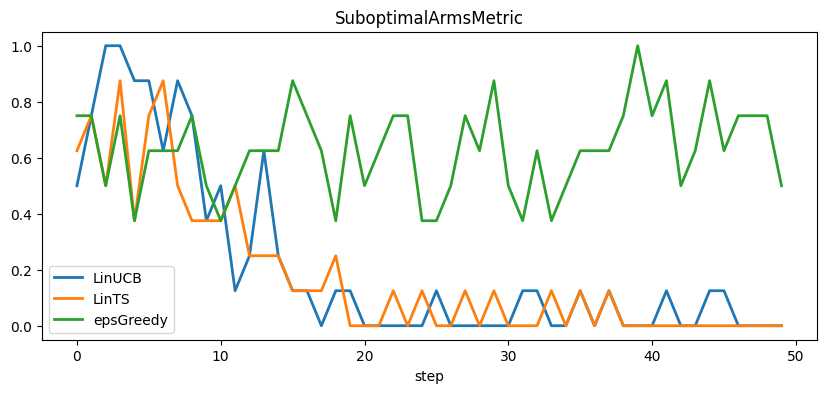

In [56]:
ax = suboptimal_df.plot(linewidth=2, fontsize=FONT_SIZE, figsize=FIG_SIZE);

# Additional customizations
ax.set_title("SuboptimalArmsMetric")
ax.set_xlabel('step');
ax.legend(fontsize=FONT_SIZE);

### get Vertex Experiment dataframe

In [57]:
experiment_df = aiplatform.get_experiment_df()
experiment_df = experiment_df[experiment_df.experiment_name == EXPERIMENT_NAME]
experiment_df.T

,0,1,2
experiment_name,01d-linear-reward-bandits-v1,01d-linear-reward-bandits-v1,01d-linear-reward-bandits-v1
run_name,epsgreedy-20240313-184653,lints-20240313-184305,linucb-20240313-183942
run_type,system.ExperimentRun,system.ExperimentRun,system.ExperimentRun
state,COMPLETE,COMPLETE,COMPLETE
param.agent_alpha,N/A,0.1,0.1
param.training_loops,50.0,50.0,50.0
param.network,QNetwork,N/A,N/A
param.forget,N/A,0.98,0.98
param.batch_size,8.0,8.0,8.0
param.runtime,3.0,3.0,3.0


In [58]:
df_list = []
i_run_names = []

for i_run_name in all_run_names:
    
    print(i_run_name)
    
    experiment_run = aiplatform.ExperimentRun(
        run_name=i_run_name,
        experiment=EXPERIMENT_NAME, 
        project=PROJECT_ID, 
        location=LOCATION
    )
    
    temp_df = experiment_run.get_time_series_data_frame()
    temp_df = temp_df.groupby('step').agg(
        {
            "AverageReturnMetric": max,
            "RegretMetric": max,
            "SuboptimalArmsMetric": max,
        }
    )

    df_list.append(temp_df)
    i_run_names.append(i_run_name)

print(f"len(df_list)     : {len(df_list)}")
print(f"len(i_run_names) : {len(i_run_names)}")

linucb-20240313-183942
lints-20240313-184305
epsgreedy-20240313-184653
len(df_list)     : 3
len(i_run_names) : 3


In [59]:
print(f"Metric table for run: {i_run_names[0]}\n")
print(f"len(df_list[0])     : {len(df_list[0])}")
df_list[0].head(3)

Metric table for run: linucb-20240313-183942

len(df_list[0])     : 49


,AverageReturnMetric,RegretMetric,SuboptimalArmsMetric
step,,,
1,-148.104324,25.380543,0.75
2,-158.701538,42.500019,1.00
3,-45.700886,44.624905,1.00


In [60]:
print(f"Metric table for run: {i_run_names[1]}\n")
print(f"len(df_list[1])     : {len(df_list[1])}")
df_list[1].head(3)

Metric table for run: lints-20240313-184305

len(df_list[1])     : 49


,AverageReturnMetric,RegretMetric,SuboptimalArmsMetric
step,,,
1,-87.296608,48.870941,0.750
2,-185.104767,27.132473,0.500
3,-180.604218,57.752823,0.875


In [61]:
print(f"Metric table for run: {i_run_names[2]}\n")
print(f"len(df_list[2])     : {len(df_list[2])}")
df_list[2].head(3)

Metric table for run: epsgreedy-20240313-184653

len(df_list[2])     : 49


,AverageReturnMetric,RegretMetric,SuboptimalArmsMetric
step,,,
1,-80.602882,64.126205,0.75
2,-19.498714,28.624956,0.50
3,-53.401146,41.501526,0.75


## Clean up

In [ ]:
# # Delete experiment
# exp = vertex_ai.Experiment(EXPERIMENT_NAME)
# exp.delete(delete_backing_tensorboard_runs=True)

# # Delete Tensorboard
# vertex_ai_tb.delete()